# BitTrack Project
## Send request and Get data

In [1]:
import requests
import csv
import json

import datetime
import time
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

# Time in UNIX format
month = 2629743
now = int(time.time())
start_time = now - 3*month
DATALENGTH = 500
ema_length = 50

url = f"http://api.coincap.io/v2/assets/bitcoin/history?interval=h1"
print(url)

# Request data from the API
response = requests.request("GET", url, headers={}, data={})
json_data = json.loads(response.text.encode('utf8'))
# print(json_data)
bitcoin_data = json_data["data"]

df = pd.DataFrame(bitcoin_data)
## Export data as a csv file
# df.to_csv('BTCUSD.csv', index=False)
print(df.sample)
# df.dtypes

# Filter only the columns we need
df = pd.DataFrame(bitcoin_data, columns=['time', 'priceUsd'])
# Get last 200 rows and REVERSE, newest price on top (index 0)
df = df[:-DATALENGTH-1:-1]
print(df.sample)

# Convert 'priceUsd' datatype to something numeric
df['priceUsd'] = pd.to_numeric(df['priceUsd'], errors='coerce', downcast='integer').fillna(0, downcast='infer')
df.dtypes
df.info()

http://api.coincap.io/v2/assets/bitcoin/history?interval=h1
<bound method NDFrame.sample of                    priceUsd           time          circulatingSupply  \
0    41782.8401902674483156  1632186000000  18821825.0000000000000000   
1    42655.9587876318227212  1632189600000  18821825.0000000000000000   
2    42949.5116536920129453  1632193200000  18821900.0000000000000000   
3    42716.4479407332967565  1632196800000  18821900.0000000000000000   
4    42458.1365614728513252  1632200400000  18821981.0000000000000000   
..                      ...            ...                        ...   
715  66406.6493901698490156  1634760000000  18849293.0000000000000000   
716  65975.3155201048881115  1634763600000  18849362.0000000000000000   
717  65789.1597904828162752  1634767200000  18849362.0000000000000000   
718  65923.4334143723763545  1634770800000  18849431.0000000000000000   
719  66047.1191030288827627  1634774400000  18849431.0000000000000000   

                         date  

In [2]:
# Check data 
prices = df['priceUsd']
print(prices)

719    66047.119103
718    65923.433414
717    65789.159790
716    65975.315520
715    66406.649390
           ...     
224    43104.838284
223    43320.453959
222    43451.017968
221    43532.272783
220    43518.684940
Name: priceUsd, Length: 500, dtype: float64


In [3]:
# Calculate and check last ema value 
count = 0
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

In [4]:
print("EMA50 H1:", ema(df['priceUsd'], count))

EMA50 H1: 64219.21148180146


In [5]:
# Process UNIX time to readable form
timeStamp =  df['time'].values.tolist()
timeStamp = [x / 1000 for x in timeStamp]

In [6]:
# Insert readable timeStamp column to 'df'
df['timeStamp'] = pd.to_datetime(timeStamp, unit='s')

In [7]:
# Check
df.sample

<bound method NDFrame.sample of               time      priceUsd           timeStamp
719  1634774400000  66047.119103 2021-10-21 00:00:00
718  1634770800000  65923.433414 2021-10-20 23:00:00
717  1634767200000  65789.159790 2021-10-20 22:00:00
716  1634763600000  65975.315520 2021-10-20 21:00:00
715  1634760000000  66406.649390 2021-10-20 20:00:00
..             ...           ...                 ...
224  1632992400000  43104.838284 2021-09-30 09:00:00
223  1632988800000  43320.453959 2021-09-30 08:00:00
222  1632985200000  43451.017968 2021-09-30 07:00:00
221  1632981600000  43532.272783 2021-09-30 06:00:00
220  1632978000000  43518.684940 2021-09-30 05:00:00

[500 rows x 3 columns]>

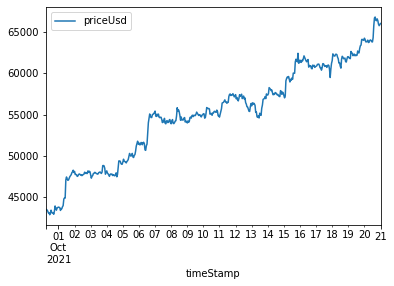

In [8]:
# Plot the data
df.plot(x ='timeStamp', y='priceUsd', kind = 'line')
plot.show()

## Calculate the possible EMA for each timeStamp
'possible' means timeStamp that have at lease 50 values before it. After that, we add EMA value along with the above figure.

In [9]:
short_df = df.head(DATALENGTH-ema_length)
short_df.reset_index()

,index,time,priceUsd,timeStamp
0,719,1634774400000,66047.119103,2021-10-21 00:00:00
1,718,1634770800000,65923.433414,2021-10-20 23:00:00
2,717,1634767200000,65789.159790,2021-10-20 22:00:00
3,716,1634763600000,65975.315520,2021-10-20 21:00:00
4,715,1634760000000,66406.649390,2021-10-20 20:00:00
...,...,...,...,...
445,274,1633172400000,47617.875765,2021-10-02 11:00:00
446,273,1633168800000,47725.054522,2021-10-02 10:00:00
447,272,1633165200000,47678.585462,2021-10-02 09:00:00
448,271,1633161600000,47781.026613,2021-10-02 08:00:00


In [10]:
short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))

C:\Users\Duy Anh\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [11]:
# short_df['N'] = np.arange(len(short_df))
short_df.insert(loc=0, column='N', value=np.arange(len(short_df)))

In [12]:
# Try modifying a value in EMA column
# short_df.loc[713,'EMA'] = 999999
# Try accessing short_df
print(short_df['EMA'].iloc[-1])

0.0


In [13]:
# Finalize 'ema' function to run in for loop
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

# Calculate ema values and replace them into the dataframe
for i in range(0, DATALENGTH-ema_length):
    count = 0
    # short_df.iloc[ ?,4 ] => 'EMA' column
    # df['priceUsd'].iloc[ i: ] => use dataFrame from newest to the last 51st row
    short_df.iloc[ i,4 ] = ema( df['priceUsd'].iloc[ i: ], count )


C:\Users\Duy Anh\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


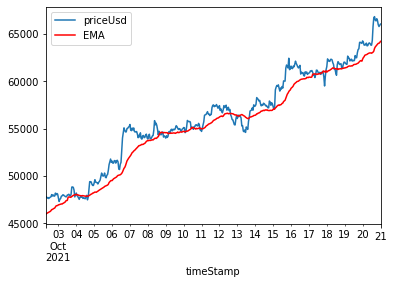

In [14]:
# Reference article https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
ax = plot.gca()
short_df.plot(kind='line',x='timeStamp',y='priceUsd', ax=ax)
short_df.plot(kind='line',x='timeStamp',y='EMA', color='red', ax=ax)
plot.show()

## Create a while loop to update price constantly

## Alarm when PRICE cross EMA

## Analyze profit/loss if trade base on EMA 

Strategy 1  
using data in the past 720 hours  
Long/Short when Price cross EMA50 in H1 timeframe, update each hour  
TP when +1000, move SL to entry  


Strategy 2  
using data in the past 720 hours  
with R:R=1:1, TP = SL = 5%  
TP 80% when reach target, move SL to entry


In [15]:
# check
df['timeStamp'].iloc[50]

Timestamp('2021-10-18 22:00:00')

In [16]:
balance = 1000
placed_order = 0
old_entry = 0

for i in reversed(range(0, DATALENGTH-ema_length-1)):
    count = 0
    old_price = df['priceUsd'].iloc[i+1]
    current_price = df['priceUsd'].iloc[i]
    timeStamp = df['timeStamp'].iloc[i]
    current_ema = ema( df['priceUsd'].iloc[i:], count )
    
    # TP if price moves 1000
    if (abs(current_price - old_entry) >= 1000):

        if (placed_order == 1):
            balance = balance * current_price / old_entry
            print(f'CLOSE BUY POSITION ' + '='*45 + \
              f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')

        elif (placed_order == -1):
            balance = balance * (2 - current_price / old_entry)
            print(f'CLOSE SELL POSITION ' + '='*45 + \
              f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')

        placed_order = 0

    # Price going up
    if (old_price <= current_ema <= current_price):
        # If placed SELL order, close that previous SELL order
        if (placed_order == -1):
            balance = balance * (2 - current_price / old_entry)
            print(f'CLOSE SELL POSITION ' + '='*45 + \
                f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')
            placed_order = 0
        # Place order if there's no position
        if (placed_order == 0):
            old_entry = current_price
            placed_order = 1
            print(f'BUY ' + '='*50 + \
                f'\nEntry: {old_entry}  \nBalance: {balance}\n')

    # Price going down
    elif (old_price >= current_ema >= current_price):
        # If placed BUY order, close that previous BUY order
        if (placed_order == 1):
            balance = balance * current_price / old_entry
            print(f'CLOSE BUY POSITION ' + '='*45 + \
                f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')
            placed_order = 0
        # Place order if there's no position
        if (placed_order == 0):
            old_entry = current_price
            placed_order = -1
            print(f'SELL ' + '='*50 + \
                f'\nEntry: {old_entry}  \nBalance: {balance}\n')

    print(f'i = {i}')
    print(f'timeStamp = {timeStamp}')
    print(f'price = {current_price}')
    print(f'ema = {current_ema}\n')


i = 448
timeStamp = 2021-10-02 08:00:00
price = 47781.02661297227
ema = 46026.23471737625

i = 447
timeStamp = 2021-10-02 09:00:00
price = 47678.585462309056
ema = 46080.47020106844

i = 446
timeStamp = 2021-10-02 10:00:00
price = 47725.05452176805
ema = 46127.991252321546

i = 445
timeStamp = 2021-10-02 11:00:00
price = 47617.87576480784
ema = 46158.38949435336

i = 444
timeStamp = 2021-10-02 12:00:00
price = 47699.24390431053
ema = 46222.656197565004

i = 443
timeStamp = 2021-10-02 13:00:00
price = 47756.195574086414
ema = 46250.322972225935

i = 442
timeStamp = 2021-10-02 14:00:00
price = 47798.88248978444
ema = 46331.3318727385

i = 441
timeStamp = 2021-10-02 15:00:00
price = 48033.94144598983
ema = 46449.14353408043

i = 440
timeStamp = 2021-10-02 16:00:00
price = 47882.438140726044
ema = 46469.72822280974

i = 439
timeStamp = 2021-10-02 17:00:00
price = 48000.027380728316
ema = 46520.34923149952

i = 438
timeStamp = 2021-10-02 18:00:00
price = 47882.76048214772
ema = 46575.175242

#### Errors:
- Sell 2 consecutive times  
- i = 441 different prices  
#### Todos:
- Add B/S on the chart where order is placed
- TP1 is 80% when price moves xxx, TP2 the rest 20% is when price crosses EMA50 
- Create a Account class